In [1]:
                   #Initial Definitions, uploading the data, and cleaning up the data
    
import tensorflow as tf
import numpy as np
import time
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


                                            #Upload data
    
#init_notebook_mode(connected=True)
data_path='CRSP_1982-2012.csv'
data_path1='Compustat_1982-2012.csv'
data_CRSP=pd.read_csv(data_path)
data_Compustat=pd.read_csv(data_path1)

                    #Renaming to making data in these colums accessible to df.column_name
    
data_CRSP = data_CRSP.rename(columns={'Names Date': 'Date', 'CUSIP Header': 'CUSIP', 'Ticker Symbol':'Ticker','Price or Bid/Ask Average': 'Price'})
data_Compustat = data_Compustat.rename(columns={'Data Date':'Date','Ticker Symbol':'Ticker'})
data_CRSP=data_CRSP.rename(columns={'Global Company Key':'GCK','Price or Bid/Ask Average':'Price'})


                           #Merge compustat and crsp data into single dataframe
    
data_CRSP.CUSIP=pd.to_numeric(data_CRSP.CUSIP, errors='ignore')
data_Compustat.CUSIP=pd.to_numeric(data_Compustat.CUSIP, errors='ignore')
data_Compustat['CUSIP'] = data_Compustat['CUSIP'].str[:-1]
data_CRSP.Date=pd.to_numeric(data_CRSP.Date, errors='ignore')
data_Compustat.Date=pd.to_numeric(data_Compustat.Date, errors='ignore')
data_CRSP['Date'] = data_CRSP['Date'].astype(str).str[:-2]
data_Compustat['Date'] = data_Compustat['Date'].astype(str).str[:-2]
df = pd.merge(data_Compustat, data_CRSP, on=['Date','CUSIP'], how='inner')
df=df.rename(columns={'Global Company Key':'GCK','Price or Bid/Ask Average':'Price'})
len(df.GCK.unique())
df=df.rename(columns={'Standard Industrial Classification Code':'SICC'})

                                #These are the features of interest chosen 
features = [
 'Current Assets - Other - Total',
 'Assets - Other - Total',
 'Account Payable/Creditors - Trade',
 'Assets - Total',
 'Common/Ordinary Equity - Total',
 'Cash and Short-Term Investments',
 'Long-Term Debt - Total',
 'Discontinued Operations',
 'Dividends - Preferred/Preference',
 'Income Before Extraordinary Items - Adjusted for Common Stock Equivalents',
 'Income Before Extraordinary Items - Available for Common',
 'Income Before Extraordinary Items',
 'Invested Capital - Total - Quarterly',
 'Current Liabilities - Other - Total',
 'Liabilities - Other',
 'Liabilities - Total',
 'Net Income (Loss)',
 'Non-Operating Income (Expense) - Total',
 'Pretax Income',
 'Property Plant and Equipment - Total (Net)',
 'Preferred/Preference Stock (Capital) - Total',
 'Preferred/Preference Stock - Redeemable',
 'Sales/Turnover (Net)',
 'Stockholders Equity > Parent > Index Fundamental > Quarterly',
 'Stockholders Equity - Total',
 'Income Taxes - Total',
 'Extraordinary Items and Discontinued Operations',
 'Cash Dividends',
 'Price'
]

IncomeCashFlowFeatures = [
 'Dividends - Preferred/Preference',
 'Cash and Short-Term Investments',
 'Sales/Turnover (Net)',
 'Net Income (Loss)',
 'Income Before Extraordinary Items - Adjusted for Common Stock Equivalents',
 'Income Before Extraordinary Items - Available for Common',
 'Income Before Extraordinary Items',
 'Pretax Income',
 'Cash Dividends',
 'Income Taxes - Total',
 'Extraordinary Items and Discontinued Operations',
 'Non-Operating Income (Expense) - Total',
]

OtherFeatures = [
 'Current Assets - Other - Total',
 'Assets - Other - Total',
 'Account Payable/Creditors - Trade',
 'Assets - Total',
 'Common/Ordinary Equity - Total',
 'Long-Term Debt - Total',
 'Discontinued Operations',
 'Invested Capital - Total - Quarterly',
 'Current Liabilities - Other - Total',
 'Liabilities - Other',
 'Liabilities - Total',
 'Property Plant and Equipment - Total (Net)',
 'Preferred/Preference Stock (Capital) - Total',
 'Preferred/Preference Stock - Redeemable',
 'Stockholders Equity > Parent > Index Fundamental > Quarterly',
 'Stockholders Equity - Total'    
]

def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)



C:\Users\Teddy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [76]:
df_now = {}     #Stores all data entries for the specific month currently iterated over 
returns={}      #Holds individual monthly returns for all stocks through 1987-2011
returns_1 = {}  #Overvalued stock returns
returns_2 = {}  #2nd quintile...
returns_3 = {}
returns_4 = {}
returns_5 = {}
portfolio = {}  #Undervalued stock returns

qrtrs=df.Date.unique()      #Find all the unique quarter dates to be used in filtering data

qrtrs.sort()

start = time.time()
m=0

df_cl = pd.DataFrame()
df_class = pd.DataFrame()

for i in range(0,len(qrtrs)):
    print(i)
    if m>0:        
        df_now[0]=df_now[1]              #df_now is a 2d dictionary holding the 2 current dataframes of interest

                                    #defining the dataframe for this month

    df_last_qrtr=pd.DataFrame()
    df_t=data_CRSP[data_CRSP['Date']== qrtrs[i]]     
    cus_list=list(df_t['CUSIP'])
    #len(cus_list)
    for cus in cus_list:
        df_te=data_Compustat[data_Compustat['CUSIP']== cus]
        df_last_qrtr=df_last_qrtr.append(df_te[df_te['Date']==qrtrs[i]].append(df_te[df_te['Date']==qrtrs[i-1]]).append(df_te[df_te['Date']==qrtrs[i-2]]))

    x1=[]
    for row in df_last_qrtr.index: 
        x1.append(row)

    df_temp=pd.DataFrame()
    for j in x1:
        x3=data_Compustat.loc[j-3:j][IncomeCashFlowFeatures].sum()
        x3['Date']=qrtrs[i]
        x3['CUSIP']=data_Compustat.loc[j]['CUSIP']
        x4=data_Compustat.loc[j][OtherFeatures]
        x5=pd.concat([x3,x4])
        df_temp=df_temp.append(pd.DataFrame(x5).T)

    df_te=df_t[['CUSIP','Price']]
    df_now[1]=pd.merge(df_temp, df_te, on=['CUSIP'], how="inner")
    df_now[1]=df_now[1].drop_duplicates(subset='CUSIP', keep='first')          #dataframe for this month


    if m>0:    
        cus_list =     list(df_now[0]['CUSIP'])
        new_cus_list = list(df_now[1]['CUSIP'])
        df_cl = pd.DataFrame()
        for cus in cus_list:
            if cus in list(new_cus_list):
                s0 = df_now[0][df_now[0]['CUSIP']== cus]
                s1 = df_now[1][df_now[1]['CUSIP']== cus]
                s0_pr = s0.iloc[0]['Price']
                s1_pr = s1.iloc[0]['Price']
                per_ret = (s1_pr-s0_pr)/s0_pr
                s0['Ret'] = per_ret
                df_cl=df_cl.append(s0)

        q=round(len(df_cl)/5)

        df_temp1=df_cl.sort_values(by=['Ret']).iloc[:q]
        df_temp1['Class']= 1
        df_temp2=df_cl.sort_values(by=['Ret']).iloc[q:2*q]
        df_temp2['Class']= 2
        df_temp3=df_cl.sort_values(by=['Ret']).iloc[2*q:3*q]
        df_temp3['Class']= 3
        df_temp4=df_cl.sort_values(by=['Ret']).iloc[3*q:4*q]
        df_temp4['Class']= 4
        df_temp5=df_cl.sort_values(by=['Ret']).iloc[4*q:]
        df_temp5['Class']= 5

        df_class = df_class.append(df_temp1).append(df_temp2).append(df_temp3).append(df_temp4).append(df_temp5)



                                        #Update the portfolio

    #portfolio[1] = list(srted['CUSIP'][:q])
    #portfolio[2] = list(srted['CUSIP'][q:2*q])
    #portfolio[3] = list(srted['CUSIP'][2*q:3*q])
    #portfolio[4] = list(srted['CUSIP'][3*q:4*q])
    #if 5*q>len(srted):
    #    portfolio[5] = list(srted['CUSIP'][4*q:])
   # portfolio[5] = list(srted['CUSIP'][4*q:5*q])

    #portfolio_1[k] = srted['CUSIP'][:q]
    #portfolio_con_3M[m] = list(srted['CUSIP'])

        #The data for this time period has processed to find under-and-overvalued stocks so we must add the to our porfolio
        #as well as look at the returns gained from stocks priorly held.  I will also do a control that tracks an even distribution investment

    m+=1

end = time.time()
print(end-start)


62
63


C:\Users\Teddy\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322


In [2]:
df_class = load_obj('df_class_win')

In [4]:
df_te=data_CRSP[['CUSIP','Price','Returns']]
df_now=pd.merge(df_class, df_te, on=['CUSIP'], how="inner")

KeyboardInterrupt: 

In [11]:
df_te=data_CRSP[['Date','CUSIP','Price','Returns']]
df_c = pd.merge(df_class,df_te, on = ['Date', 'CUSIP'], how = 'inner')

,Dividends - Preferred/Preference,Cash and Short-Term Investments,Sales/Turnover (Net),Net Income (Loss),Income Before Extraordinary Items - Adjusted for Common Stock Equivalents,Income Before Extraordinary Items - Available for Common,Income Before Extraordinary Items,Pretax Income,Cash Dividends,Income Taxes - Total,...,Property Plant and Equipment - Total (Net),Preferred/Preference Stock (Capital) - Total,Preferred/Preference Stock - Redeemable,Stockholders Equity > Parent > Index Fundamental > Quarterly,Stockholders Equity - Total,Price_x,Ret,Class,Price_y,Returns
0,0,360.387,1736.04,120.036,122.673,122.673,122.673,189.334,62.387,66.661,...,1521.99,0,0,676.612,NaN,80.000,-0.767188,1,80.000,-0.009288
1,0,2996.09,4040.03,539.717,539.717,539.717,539.717,909.299,538.968,369.582,...,7428.28,0,0,5141.24,NaN,93.500,-0.683155,1,93.500,-0.019659
2,0,15.339,13.107,1.002,1.002,1.002,1.002,1.843,0.66,0.841,...,0.608,0,0,8.937,NaN,23.125,-0.637838,1,23.125,0.468254
3,0,231.706,1458.65,154.976,154.976,154.976,154.976,270.314,123.532,115.338,...,1005.52,0,0,801.9,NaN,60.125,-0.553015,1,60.125,0.051416
4,0,80.472,278.021,18.496,18.496,18.496,18.496,38.866,0,20.37,...,31.506,0,0,68.781,NaN,35.625,-0.536842,1,35.625,0.410891
5,0,55.325,156.253,13.968,13.968,13.968,13.968,22.866,1.782,8.898,...,4.043,0,0,34.648,NaN,27.500,-0.536364,1,27.500,0.447368
6,4.175,5648.49,1522.26,171.963,167.788,167.788,171.963,238.997,0,67.034,...,288.505,125.282,1.326,1576.4,NaN,56.250,-0.533333,1,56.250,-0.022931
7,0.055,117.922,181.412,12.615,12.56,12.56,12.615,24.015,5.061,11.4,...,17.13,0,0,50.323,NaN,38.000,-0.526316,1,38.000,0.101449
8,0,87.551,150.593,13.099,13.099,13.099,13.099,23.53,0.978,10.431,...,50.29,0,0,74.521,NaN,65.000,-0.523077,1,65.000,0.026457
9,0,2.153,130.504,4.021,4.021,4.021,4.021,7.912,0,3.891,...,25.611,0,0,29.605,NaN,28.500,-0.521930,1,28.500,-0.004367


In [10]:
df_c = pd.merge(df_class,df_te, on = ['Date', 'CUSIP'], how = 'inner')

In [49]:
new_cus_list = list(df_now[1]['CUSIP'])
df_cl = pd.DataFrame()
for cus in cus_list:
    if cus in list(new_cus_list):
        s0 = df_now[0][df_now[0]['CUSIP']== cus]
        s1 = df_now[1][df_now[1]['CUSIP']== cus]
        s0_pr = s0.iloc[0]['Price']
        s1_pr = s1.iloc[0]['Price']
        per_ret = (s1_pr-s0_pr)/s0_pr
        s0['Ret'] = per_ret
        df_cl=df_cl.append(s0)
    

C:\Users\Teddy\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [64]:
q=round(len(df_cl)/5)
df_class = pd.DataFrame()

In [66]:
df_temp1=df_cl.sort_values(by=['Ret']).iloc[:q]
df_temp1['Class']= 1
df_temp2=df_cl.sort_values(by=['Ret']).iloc[q:2*q]
df_temp2['Class']= 2
df_temp3=df_cl.sort_values(by=['Ret']).iloc[2*q:3*q]
df_temp3['Class']= 3
df_temp4=df_cl.sort_values(by=['Ret']).iloc[3*q:4*q]
df_temp4['Class']= 4
df_temp5=df_cl.sort_values(by=['Ret']).iloc[4*q]
df_temp5['Class']= 5

df_class = df_class.append(df_temp1).append(df_temp2).append(df_temp3).append(df_temp4).append(df_temp5)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [112]:
df_class

,Dividends - Preferred/Preference,Cash and Short-Term Investments,Sales/Turnover (Net),Net Income (Loss),Income Before Extraordinary Items - Adjusted for Common Stock Equivalents,Income Before Extraordinary Items - Available for Common,Income Before Extraordinary Items,Pretax Income,Cash Dividends,Income Taxes - Total,...,Liabilities - Other,Liabilities - Total,Property Plant and Equipment - Total (Net),Preferred/Preference Stock (Capital) - Total,Preferred/Preference Stock - Redeemable,Stockholders Equity > Parent > Index Fundamental > Quarterly,Stockholders Equity - Total,Price,Ret,Class
1101,0,360.387,1736.04,120.036,122.673,122.673,122.673,189.334,62.387,66.661,...,52.062,1674.27,1521.99,0,0,676.612,NaN,80.000,-0.767188,1
2025,0,2996.09,4040.03,539.717,539.717,539.717,539.717,909.299,538.968,369.582,...,226.443,4648.41,7428.28,0,0,5141.24,NaN,93.500,-0.683155,1
1297,0,15.339,13.107,1.002,1.002,1.002,1.002,1.843,0.66,0.841,...,0,1.294,0.608,0,0,8.937,NaN,23.125,-0.637838,1
1608,0,231.706,1458.65,154.976,154.976,154.976,154.976,270.314,123.532,115.338,...,154.464,704.309,1005.52,0,0,801.9,NaN,60.125,-0.553015,1
2079,0,80.472,278.021,18.496,18.496,18.496,18.496,38.866,0,20.37,...,0,209.409,31.506,0,0,68.781,NaN,35.625,-0.536842,1
2314,0,55.325,156.253,13.968,13.968,13.968,13.968,22.866,1.782,8.898,...,0,89.221,4.043,0,0,34.648,NaN,27.500,-0.536364,1
1354,4.175,5648.49,1522.26,171.963,167.788,167.788,171.963,238.997,0,67.034,...,697.447,20589.4,288.505,125.282,1.326,1576.4,NaN,56.250,-0.533333,1
828,0.055,117.922,181.412,12.615,12.56,12.56,12.615,24.015,5.061,11.4,...,0,22.112,17.13,0,0,50.323,NaN,38.000,-0.526316,1
613,0,87.551,150.593,13.099,13.099,13.099,13.099,23.53,0.978,10.431,...,0.04,83.873,50.29,0,0,74.521,NaN,65.000,-0.523077,1
2277,0,2.153,130.504,4.021,4.021,4.021,4.021,7.912,0,3.891,...,1.631,46.725,25.611,0,0,29.605,NaN,28.500,-0.521930,1


In [117]:
#def Agnostic1M(model):    
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


df_now = {}     #Stores all data entries from a specific time 
overvalued = {}     #Overvalued Stocks
undervalued = {}     #Undervalued Stocks
returns={}
returns_1 = {}
returns_2 = {}
returns_3 = {}
returns_4 = {}
returns_5 = {}
portfolio = {}
df_so_far=pd.DataFrame()
#Find all the unique quarter dates to be used in filtering data
qrtrs=df.Date.unique()
qrtrs.sort()

start = time.time()
m=0

for i in range(62,len(qrtrs)-1):
    print(i)
    if m>0:
        df_now[0]=df_now[1]
   # print(time.time()-start)
    df_now[1] = df_class[df_class['Date']==qrtrs[i]]

    #Calculate returns from last month's portfolio
    ret_1=[]
    if m>1:
        for j in range(0,len(portfolio[1])):
            if portfolio[1][j] in list(df_now[1]['CUSIP']):
                or_pr = float(list(df_now[0][df_now[0]['CUSIP']== portfolio[1][j]]['Price'])[0])
                new_pr = float(list(df_now[1][df_now[1]['CUSIP']== portfolio[1][j]]['Price'])[0])
                per_ret = (new_pr-or_pr)/or_pr 
                ret_1.append(per_ret)
        returns_1[m]=ret_1

    ret_2=[]
    if m>1:
        for j in range(0,len(portfolio[2])):
            if portfolio[2][j] in list(df_now[1]['CUSIP']):
                or_pr = float(list(df_now[0][df_now[0]['CUSIP']== portfolio[2][j]]['Price'])[0])
                new_pr = float(list(df_now[1][df_now[1]['CUSIP']== portfolio[2][j]]['Price'])[0])
                per_ret = (new_pr-or_pr)/or_pr 
                ret_2.append(per_ret)
        returns_2[m]=ret_2

    ret_3=[]
    if m>1:
        for j in range(0,len(portfolio[3])):
            if portfolio[3][j] in list(df_now[1]['CUSIP']):
                or_pr = float(list(df_now[0][df_now[0]['CUSIP']== portfolio[3][j]]['Price'])[0])
                new_pr = float(list(df_now[1][df_now[1]['CUSIP']== portfolio[3][j]]['Price'])[0])
                per_ret = (new_pr-or_pr)/or_pr 
                ret_3.append(per_ret)
        returns_3[m]=ret_3

    ret_4=[]
    if m>1:
        for j in range(0,len(portfolio[4])):
            if portfolio[4][j] in list(df_now[1]['CUSIP']):
                or_pr = float(list(df_now[0][df_now[0]['CUSIP']== portfolio[4][j]]['Price'])[0])
                new_pr = float(list(df_now[1][df_now[1]['CUSIP']== portfolio[4][j]]['Price'])[0])
                per_ret = (new_pr-or_pr)/or_pr 
                ret_4.append(per_ret)
        returns_4[m]=ret_4

    # Undervalued Stocks
    ret_5=[]
    if m>1:
        for j in range(0,len(portfolio[5])):
            if portfolio[5][j] in list(df_now[1]['CUSIP']):
                or_pr = float(list(df_now[0][df_now[0]['CUSIP']== portfolio[5][j]]['Price'])[0])
                new_pr = float(list(df_now[1][df_now[1]['CUSIP']== portfolio[5][j]]['Price'])[0])
                per_ret = (new_pr-or_pr)/or_pr 
                ret_5.append(per_ret)
        returns_5[m]=ret_5

    #Run Model to sort the stock's into quintiles based off of mispricing
    if m>0:
        X = df_so_far.loc[:, features]    #Extract feature variable data
        X = X.fillna(X.mean())
        #X = scalar.fit_transform(X_tempscaled)
        #X = np.nan_to_num(X)
        Y = df_so_far.loc[:,['Class']].values   #Extract target data
        #inds = [item for sublist in np.argwhere(np.isnan(Y.values)[:,0]) for item in sublist]  #indices of nan for Y
        #X_train, X_test = train_test_split(df, test_size=0.2)
        #X=X.drop(X.index[inds])
        #Y=Y.drop(Y.index[inds])
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=27)
        if m>20:
            X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=10000, random_state=27)

        model.fit(X_train.values, y_train.ravel())    #Fit the data using linear regression
        #plt.plot((Y.flatten()-model.predict(X))/Y.flatten())

        X_new = df_now[1].loc[:, features]
        Y_new = df_now[1].loc[:,['Class']].values

        mod_pred=model.predict(X_test.values)
        print(accuracy_score(mod_pred, y_test.ravel()))


        #Store the over/undervalued stocks into a dictionary
        #overvalued=pd.DataFrame(srted.head(q))    #pick off top quintile of stocks
        #undervalued=pd.DataFrame(srted.tail(q))   #pick off bottom quintile of stocks

        #Update the portfolio

        temp = pd.DataFrame()
        temp['pred'] = model.predict(df_now[1].loc[:, features].fillna(X.mean()).values)
        temp['CUSIP'] = df_now[1]['CUSIP'].values
        temp['Price'] = df_now[1]['Price'].values

        portfolio[1] = list(temp[temp['pred']==1]['CUSIP'])
        portfolio[2] = list(temp[temp['pred']==2]['CUSIP'])
        portfolio[3] = list(temp[temp['pred']==3]['CUSIP'])
        portfolio[4] = list(temp[temp['pred']==4]['CUSIP'])
        portfolio[5] = list(temp[temp['pred']==5]['CUSIP'])
    #portfolio_con_3M[m] = list(srted['CUSIP'])

        #The data for this time period has processed to find under-and-overvalued stocks so we must add the to our porfolio
        #as well as look at the returns gained from stocks priorly held.  I will also do a control that tracks an even distribution investment
    df_so_far = df_so_far.append(df_now[1])
    m+=1
dt=qrtrs[i]
returns[1]=returns_1
returns[2]=returns_2
returns[3]=returns_3
returns[4]=returns_4
returns[5]=returns_5

end = time.time()
print(end-start)

    #return returns

62
63
0.21544715447154472
64
0.24180327868852458
65
0.23251028806584362
66
0.23622448979591837
67
0.24065040650406505
68
0.24509803921568626
69
0.2301169590643275
70
0.23019161056447437
71
0.22467986030267753
72
0.23029661016949152
73
0.23126338329764454
74
0.23159784560143626
75
0.2294782319707544
76
0.22779503105590063
77
0.2333576110706482
78
0.23443273573285892
79
0.22992370360791414
80
0.2289673779740005
81
0.23534211446555542
82
0.23094867807153965
83
0.22545141411695058
84
0.2259941557616567
85
0.23028360762391267
86
0.22845034932997366
87
0.2309890493433969
88
0.23478550742754756
89
0.2334862385321101
90
0.2316616337295975
91
0.23316928049362765
92
0.23025373530191848
93
0.2278399018137188
94
0.22837900144908443
95
0.232089682956735
96
0.22841208461076276
97
0.23142298098609432
98
0.22816280351599896
99
0.22949247669679748
100
0.23097289288849868
101
0.22994409830160234
102
0.22969780362427955
103
0.22987210333037864
104
0.22983656451433307
105
0.23069197914019868
106
0.2294171

In [118]:
save_obj(returns, 'returns_cl_KNC')

In [109]:
from sklearn.model_selection import train_test_split
x=[]
for k in range(1,300):
    df_now = {}
    qrtrs=df.Date.unique()      #Find all the unique quarter dates to be used in filtering data

    qrtrs.sort()

    df_now[0] = df_class[df_class['Date']==qrtrs[63]]
    df_now[1] = df_class[df_class['Date']==qrtrs[64]]

    X = df_now[0].loc[:, features]    #Extract feature variable data
    X = X.fillna(X.mean())
    #X = scalar.fit_transform(X_tempscaled)
    #X = np.nan_to_num(X)
    Y = df_now[0].loc[:,['Class']].values   #Extract target data
    #inds = [item for sublist in np.argwhere(np.isnan(Y.values)[:,0]) for item in sublist]  #indices of nan for Y
    #X_train, X_test = train_test_split(df, test_size=0.2)
    #X=X.drop(X.index[inds])
    #Y=Y.drop(Y.index[inds])
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=27)

    model = KNeighborsClassifier(k)
    model.fit(X_train.values, y_train.ravel())    #Fit the data using linear regression
    #plt.plot((Y.flatten()-model.predict(X))/Y.flatten())

    X_new = df_now[1].loc[:, features]
    X_new = X_new.fillna(X.mean())
    Y_new = df_now[1].loc[:,['Class']].values
    pp=model.predict(X_test.values)
    x.append(accuracy_score(pp, y_test.ravel()))
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156


KeyboardInterrupt: 

In [114]:
returns_KNC = Agnostic1M(KNeighborsClassifier(41))

371
0.03600144386291504


In [102]:
 #Function to calculate the net return at each new month of 1 dollar invested in the first month over the sample time
    
def TotalReturns1M(returns):
    total_ret_0=[1]  #0: Control
    total_ret_1=[1]  # Overvalued
    total_ret_2=[1]
    total_ret_3=[1]
    total_ret_4=[1]
    total_ret_5=[1]  # Undervalued
    avg_ret_0=[1]
    avg_ret_1=[1]
    avg_ret_2=[1]
    avg_ret_3=[1]
    avg_ret_4=[1]
    avg_ret_5=[1]
    #total_ret_con=[1,1,1]
    #total_ret_con=[returns_con[4]/5]
    tot=0
    i=2
    for j in range(1,len(returns[1])):
        avg_ret_1.append(1 + np.sum(returns[1][i])/(len(returns[1][i])))
        total_ret_1.append(avg_ret_1[j]*total_ret_1[j-1])
        avg_ret_2.append(1+np.sum(returns[2][i])/(len(returns[2][i])))
        total_ret_2.append(avg_ret_2[j]*total_ret_2[j-1])
        avg_ret_3.append(1+np.sum(returns[3][i])/(len(returns[3][i])))
        total_ret_3.append(avg_ret_3[j]*total_ret_3[j-1])
        avg_ret_4.append(1+np.sum(returns[4][i])/(len(returns[4][i])))
        total_ret_4.append(avg_ret_4[j]*total_ret_4[j-1])
        avg_ret_5.append(1+np.sum(returns[5][i])/(len(returns[5][i])))
        total_ret_5.append(avg_ret_5[j]*total_ret_5[j-1])
        avg_ret_0.append((avg_ret_1[j] + avg_ret_2[j] + avg_ret_3[j] + avg_ret_4[j] + avg_ret_5[j])/5)
        total_ret_0.append(avg_ret_0[j]*total_ret_0[j-1])
        i+=1
    total_ret={}
    total_ret[0]=total_ret_0
    total_ret[1]=total_ret_1
    total_ret[2]=total_ret_2
    total_ret[3]=total_ret_3
    total_ret[4]=total_ret_4
    total_ret[5]=total_ret_5
    avg_ret={}
    avg_ret[0]=avg_ret_0
    avg_ret[1]=avg_ret_1
    avg_ret[2]=avg_ret_2
    avg_ret[3]=avg_ret_3
    avg_ret[4]=avg_ret_4
    avg_ret[5]=avg_ret_5
    return total_ret, avg_ret


In [103]:
total_ret_KNC, avg_ret_KNC = TotalReturns1M(returns_KNC)

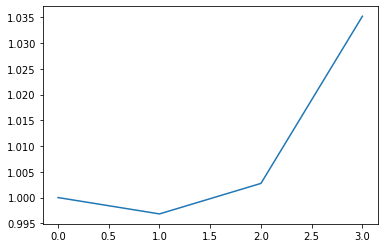

In [104]:
plt.plot(list(total_ret_KNC[5]), label = 'KNC')

In [73]:
df_now[1]['CUSIP'].values

array(['88250810', '124010', '58753310', ..., '635610', '25256310',
       '75920010'], dtype=object)

In [76]:
temp = pd.DataFrame()
temp['pred'] = model.predict(df_now[1].loc[:, features].fillna(X.mean()).values)
temp['CUSIP'] = df_now[1]['CUSIP'].values

In [78]:
temp[temp['pred']==4]

,pred,CUSIP
0,4,88250810
2,4,58753310
7,4,87537010
8,4,40425110
9,4,65163910
16,4,85224510
19,4,58283410
22,4,73109510
24,4,11704310
26,4,80660510
